In [ ]:
import os
import openai
import anthropic
import together
import subprocess
import re

# open ai API key
openai_api_key=''
# anthropic API key
claude_api_key = ''
# together AI API key
together_api_key = ''

In [2]:
# read the prompt from the prompt text file titled "paramesti.txt"
with open("../prompts/paramesti.txt", "r") as f:
    prompt = f.read()

prompt = str(prompt)
print(prompt)

You're an expert in stochastic modeling and you're tasked to solve the following problem.

Objective:
----------
Estimate the unknown parameter vector of a two-dimensional gamma distribution using maximum likelihood estimation.

Problem Description:
--------------------
A simulation generates i.i.d. observations Y_j = (y_{1,j}, y_{2,j}) from a two-dimensional gamma distribution defined over [0, infinity) x [0, infinity). The density function is given by

    f(y_1, y_2; x*) = (exp(-y_1) * y_1^(x*_1 * y_2 - 1)) / Gamma(x*_1 * y_2) *
                       (exp(-y_2) * y_2^(x*_2 - 1)) / Gamma(x*_2),
    for y_1, y_2 > 0,

where the true parameter vector x* = (x*_1, x*_2) is unknown. The function

    g(x) = E[ log( f(Y; x) ) ] = integral_0^infinity log( f(y; x) ) * f(y; x*) dy

is maximized by x*, and its sample estimator

    G_m(x) = (1/m) * sum_(j=1)^m log( f(Y_j; x) )

is consistent. In this context, each component of Y_j is a gamma random variable, and the goal is to recover x* thro

In [3]:
claude_client = anthropic.Anthropic(api_key = claude_api_key)
openai_client = openai.OpenAI(api_key = openai_api_key)
togetherai_client = together.Together(api_key=together_api_key)

## GPT-4o

In [4]:
completion = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are an expert in probability theory and stochastic modeling."},
        {"role": "user", "content": prompt},
    ]
)

# get the response
response = completion.choices[0].message.content

In [5]:
print(response)

To tackle this problem, we can employ a simulation-based approach since the joint density function given does not readily lend itself to a closed-form maximum likelihood solution due to the complexity introduced by the interaction between the two components of the vector Y in the gamma distributions.

The workflow is divided into these key steps:

1. **Data Simulation**: Generate i.i.d. samples from the defined two-dimensional gamma distribution using the known parameter vector \( x^* \).

2. **Log Likelihood Computation**: For given parameter candidates \( x = (x_1, x_2) \), compute the sample log likelihood function \( G_m(x) \).

3. **Optimization**: Apply an optimization method that efficiently searches for the \( x \) that maximizes \( G_m(x) \).

Below is a Python implementation encapsulating the above steps:

```python
import numpy as np
from scipy.special import gamma, gammaln
from scipy.optimize import minimize

# Step 1: Data generation function
def generate_data(n_samples, x

In [6]:
import numpy as np
from scipy.special import gamma, gammaln
from scipy.optimize import minimize

# Step 1: Data generation function
def generate_data(n_samples, x_star):
    y2 = np.random.gamma(shape=x_star[1], scale=1, size=n_samples)
    y1 = np.random.gamma(shape=x_star[0] * y2, scale=1)
    return np.vstack((y1, y2)).T

# Step 2: Log likelihood computation
def sample_log_likelihood(X, data):
    y1, y2 = data[:, 0], data[:, 1]
    x1, x2 = X

    term1 = -y1 + (x1 * y2 - 1) * np.log(y1) - gammaln(x1 * y2)
    term2 = -y2 + (x2 - 1) * np.log(y2) - gammaln(x2)
    
    log_likelihood = np.sum(term1 + term2)
    return log_likelihood

# Step 3: Optimization function
def optimize_mle(data, initial_guess, budget):
    def objective(X):
        # Negative because we are maximizing
        return -sample_log_likelihood(X, data)
    
    bounds = [(0.1, 10), (0.1, 10)]
    result = minimize(objective, initial_guess, bounds=bounds, options={'maxiter': budget, 'disp': True})
    return result.x, -result.fun

# Parameters
true_parameters = np.array([2, 5])
initial_guess = np.array([1, 1])
n_samples = 1000
budget = 1000

# Run data generation
data = generate_data(n_samples, true_parameters)

# Perform optimization
estimated_parameters, estimated_log_likelihood = optimize_mle(data, initial_guess, budget)

# Output results
print(f"Estimated parameters: {estimated_parameters}")
print(f"Estimated log likelihood: {estimated_log_likelihood}")

Estimated parameters: [2.00076309 5.02050859]
Estimated log likelihood: -4611.680006069343


## o1

In [7]:
completion = openai_client.chat.completions.create(
    model="o1",
    messages=[
        {"role": "system", "content": "You are an expert in probability theory and stochastic modeling."},
        {"role": "user", "content": prompt},
    ]
)

# get the response
response = completion.choices[0].message.content

In [8]:
print(response)

Solution Explanation

We have i.i.d. samples Y₍ⱼ₎ = (y₁,ⱼ, y₂,ⱼ) from the density

  f(y₁, y₂; x) 
  = [ exp(-y₁) · y₁^(x₁·y₂ - 1 ) / Γ(x₁·y₂ ) ] 
    × [ exp(-y₂) · y₂^(x₂ - 1 )        / Γ(x₂)       ],
  
where x = (x₁, x₂) is the unknown parameter vector to be estimated. Below is a two-part solution:

1. Partially Closed-Form MLE Approach
2. Simulation and Numerical Validation

--------------------------------------------------------------------------------
1. Partially Closed-Form MLE Approach
--------------------------------------------------------------------------------

▌ Log-Likelihood for One Sample

The log of f(y₁, y₂; x) decomposes into two parts:

  log f(y₁, y₂; x) 
   =  log [ exp(-y₁) · y₁^(x₁y₂ - 1 ) / Γ(x₁y₂) ]
     + log [ exp(-y₂) · y₂^(x₂ - 1  ) / Γ(x₂)     ].

Expanding and regrouping:

  = -y₁ + (x₁y₂ - 1) log(y₁) - log Γ(x₁y₂)
    -y₂ + (x₂ - 1)   log(y₂) - log Γ(x₂).

Given m independent observations {(y₁,ⱼ, y₂,ⱼ)}ⱼ₌₁..m, the log-likelihood is:

  L(x) = ∑(ⱼ=1.

In [9]:
import numpy as np
import scipy.special as sps
from scipy.optimize import bisect, root_scalar

def gamma2d_sample(x_true, m, rng=None):
    """
    Generate m i.i.d. samples from the 2D Gamma distribution:
      y1 ~ Gamma(shape = x1 * y2, rate=1)
      y2 ~ Gamma(shape = x2,        rate=1).
    Since y2 is independent of y1, we first sample y2, then y1 conditional on y2.
    """
    if rng is None:
        rng = np.random.default_rng()
    x1_true, x2_true = x_true
    # Sample y2 ~ Gamma(shape=x2_true, scale=1)
    y2 = rng.gamma(shape=x2_true, scale=1.0, size=m)
    # For each y2_j, sample y1_j ~ Gamma(shape=x1_true*y2_j, scale=1)
    y1 = np.array([rng.gamma(shape=x1_true * yy, scale=1.0) for yy in y2])
    return np.column_stack((y1, y2))

def log_likelihood(x, data):
    """
    Computes the log-likelihood sum_j log f(y_j; x).
    data is an (m,2) array with columns (y1_j, y2_j).
    """
    x1, x2 = x
    y1 = data[:,0]
    y2 = data[:,1]
    # log f(y1, y2; x) = ...
    # part1 = -y1 + (x1*y2 -1)*log(y1) - log Gamma(x1*y2)
    # part2 = -y2 + (x2   -1)*log(y2) - log Gamma(x2)
    ll_part1 = -y1 + (x1*y2 - 1)*np.log(y1) - sps.gammaln(x1*y2)
    ll_part2 = -y2 + (x2 - 1)*np.log(y2)    - sps.gammaln(x2)
    return np.sum(ll_part1 + ll_part2)

def digamma_inverse(target, bracket=(1e-3, 100.0)):
    """
    Solve psi(z) = target for z>0 using a bisection within bracket.
    Adjust bracket if needed for your data.
    """
    def f(z):
        return sps.digamma(z) - target
    return bisect(f, bracket[0], bracket[1])

def solve_for_x2(data):
    """
    Solve the MLE equation for x2:
      digamma(x2) = average of log(y2).
    """
    y2 = data[:,1]
    avg_log_y2 = np.mean(np.log(y2))
    # x2 solves psi(x2) = avg_log_y2
    # We'll guess a bracket e.g. (1e-3, 100); or refine if data is large
    return digamma_inverse(avg_log_y2, bracket=(1e-3, 1e4))

def solve_for_x1(data, x1_init=2.0):
    """
    Solve the MLE condition for x1:
      sum_j [ y2_j * psi(x1 * y2_j) ] = sum_j [ y2_j * log(y1_j) ].
    We'll do a root_scalar with bisection or Newton.
    """
    y1 = data[:,0]
    y2 = data[:,1]
    sum_y2_logy1 = np.sum(y2 * np.log(y1))

    def H(x1):
        return np.sum(y2 * sps.digamma(x1 * y2)) - sum_y2_logy1

    # We must have x1>0. We'll do a bracket search. 
    # If data is fairly large, you might want to refine bracket automatically.
    bracket_min = 1e-3
    bracket_max = 100.0
    # Expand bracket if needed:
    while H(bracket_max) < 0:
        bracket_max *= 2.0
        if bracket_max > 1e12:  # safeguard
            break
    root_result = root_scalar(H, bracket=[bracket_min, bracket_max], method='bisect')
    return root_result.root

def estimate_parameters_closed_form(data):
    """
    Estimate (x1, x2) via the partial closed-form approach:
      1) Solve for x2 from digamma(x2) = average(log(y2)).
      2) Solve for x1 from sum_j y2_j psi(x1 y2_j) = sum_j y2_j log(y1_j).
    """
    x2_hat = solve_for_x2(data)
    x1_hat = solve_for_x1(data)
    return (x1_hat, x2_hat)


def main():
    # ------------------------------
    # 1. Generate data
    # ------------------------------
    m = 2000                      # number of samples
    true_x = (2.0, 5.0)           # true parameter vector
    rng = np.random.default_rng(123)
    data = gamma2d_sample(true_x, m, rng=rng)

    # ------------------------------
    # 2. Baseline log-likelihood at x=[1,1]
    # ------------------------------
    baseline_x = (1.0, 1.0)
    ll_baseline = log_likelihood(baseline_x, data)
    print("Baseline guess x = (1,1)")
    print("Log-likelihood(1,1) =", ll_baseline)

    # ------------------------------
    # 3. Estimate x via partial closed-form approach
    # ------------------------------
    x_hat = estimate_parameters_closed_form(data)
    ll_hat = log_likelihood(x_hat, data)
    print("\nPartial Closed-Form MLE Approach:")
    print("Estimated x =", x_hat)
    print("Log-likelihood(x_hat) =", ll_hat)

    # ------------------------------
    # 4. Compare to the truth
    # ------------------------------
    print("\nTrue x         =", true_x)
    print("Estimated x    =", x_hat)
    print("LL difference  =", ll_hat - ll_baseline)
    print("Improvement?   =", "Yes" if ll_hat > ll_baseline else "No")

if __name__ == "__main__":
    main()

Baseline guess x = (1,1)
Log-likelihood(1,1) = -18196.433743595044

Partial Closed-Form MLE Approach:
Estimated x = (2.0128422787248335, 4.976167154490353)
Log-likelihood(x_hat) = -9226.038105297983

True x         = (2.0, 5.0)
Estimated x    = (2.0128422787248335, 4.976167154490353)
LL difference  = 8970.395638297061
Improvement?   = Yes


## o3-mini

In [10]:
completion = openai_client.chat.completions.create(
    model="o3-mini",
    messages=[
        {"role": "system", "content": "You are an expert in probability theory and stochastic modeling."},
        {"role": "user", "content": prompt},
    ]
)

# get the response
response = completion.choices[0].message.content

In [11]:
print(response)

Below is one complete solution write‐up that explains our reasoning and then shows a self‐contained Python simulation and optimization procedure.

──────────────────────────────
1. Explanation and Methodology
──────────────────────────────
We are given independent observations Yⱼ = (y₁, y₂) generated from the density

  f(y₁,y₂; x) = { exp(–y₁)·y₁^(x₁·y₂ – 1) / Γ(x₁·y₂) } · { exp(–y₂)·y₂^(x₂ – 1) / Γ(x₂) },
     for y₁, y₂ > 0,

with the “true” parameter vector x* = (x₁*, x₂*) unknown (default x* = [2, 5]). In words, y₂ is gamma distributed with shape parameter x₂ and scale 1, and then (conditional on y₂) y₁ is gamma distributed with shape parameter x₁·y₂ and scale 1.

A maximum likelihood (ML) approach will maximize the expected log likelihood

  g(x) = E[ log f(Y; x) ],
     = ∫ log f(y; x) f(y; x*) dy.
 
When we write the log likelihood for a single observation (dropping constants and writing in “nice” form) we have

  ℓ(x; y₁,y₂) =
    – y₁ – y₂ + (x₁·y₂ – 1)·ln(y₁)
       – ln Γ(x

Baseline x = [1. 1.] Average log likelihood = -9.218 (SE = 0.113)
Best candidate x = [2.111, 5.526] with Average log likelihood = -4.646 (SE = 0.030)


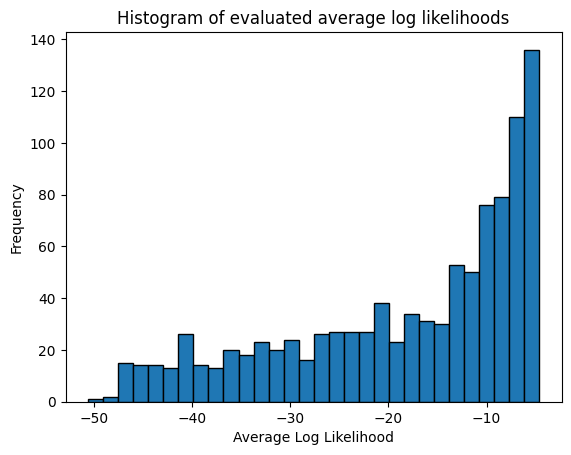

In [12]:
import numpy as np
from scipy.special import gammaln
import matplotlib.pyplot as plt

# -- Settings --
# True parameters and starting guess:
x_true = np.array([2.0, 5.0])   # x* = [x1*, x2*]
x_start = np.array([1.0, 1.0])
# Budget for candidate evaluation:
BUDGET = 1000  
# Number of observations in simulation:
m = 1000  
# Random seed for reproducibility:
np.random.seed(123)

# -- Step 1: Data Generation --
# Generate observations Y = (y1, y2) as per the model:
#   y2 ~ Gamma(shape = x2*, scale = 1)
#   y1 | y2 ~ Gamma(shape = x1* * y2, scale = 1)
y2_samples = np.random.gamma(shape=x_true[1], scale=1.0, size=m)
y1_samples = np.empty(m)
for j in range(m):
    shape_param = x_true[0] * y2_samples[j]
    # In case shape_param is extremely small, numpy gamma can handle shape > 0.
    y1_samples[j] = np.random.gamma(shape=shape_param, scale=1.0)

# Combine into one dataset (each row is an observation):
Y = np.column_stack((y1_samples, y2_samples))

# -- Step 2: Define the log likelihood function for a candidate parameter x --
def log_likelihood_single(x, y):
    """
    Computes the log likelihood for a single observation y = (y1, y2)
    given candidate parameter vector x = [x1, x2].
    """
    y1, y2 = y
    x1, x2 = x
    term1 = -y1 - y2
    term2 = (x1 * y2 - 1.0) * np.log(y1)
    term3 = -gammaln(x1 * y2)
    term4 = (x2 - 1.0) * np.log(y2)
    term5 = -gammaln(x2)
    return term1 + term2 + term3 + term4 + term5

def sample_log_likelihood(x, Y):
    """
    Returns the average log likelihood over all m observations given candidate x.
    Also returns the standard error (std divided by sqrt(m)) of the sample log likelihood.
    """
    logls = np.array([log_likelihood_single(x, y) for y in Y])
    avg = np.mean(logls)
    std_error = np.std(logls) / np.sqrt(len(Y))
    return avg, std_error

# -- Step 3: Evaluate the baseline at x_start --
baseline_avg, baseline_se = sample_log_likelihood(x_start, Y)
print("Baseline x =", x_start, "Average log likelihood = {:.3f} (SE = {:.3f})".format(baseline_avg, baseline_se))

# -- Step 4: Optimization via Direct Search --
# We randomly sample BUDGET candidate solutions from Uniform(0,10) x Uniform(0,10).
candidate_x = np.random.uniform(low=0.1, high=10.0, size=(BUDGET, 2))
# For storing evaluations:
scores = np.zeros(BUDGET)
ses = np.zeros(BUDGET)

for i in range(BUDGET):
    score, se = sample_log_likelihood(candidate_x[i], Y)
    scores[i] = score
    ses[i] = se

# Identify the candidate with maximum average log likelihood:
best_index = np.argmax(scores)
best_x = candidate_x[best_index]
best_score = scores[best_index]
best_se = ses[best_index]

print("Best candidate x = [{:.3f}, {:.3f}] with Average log likelihood = {:.3f} (SE = {:.3f})".format(
    best_x[0], best_x[1], best_score, best_se))

# -- Optional: Plot histogram of scores (for visualization) --
plt.hist(scores, bins=30, edgecolor='k')
plt.xlabel("Average Log Likelihood")
plt.ylabel("Frequency")
plt.title("Histogram of evaluated average log likelihoods")
plt.show()

## Claude 3.5 Sonnet

In [13]:
response = claude_client.messages.create(
    model="claude-3-5-sonnet-20241022",  # Or another Claude 3 model
    max_tokens=4096,
    system="You are an expert in probability theory and stochastic modeling.",
    messages=[
        {"role": "user", "content": prompt}
    ]
)

print(response.content[0].text)

I'll help solve this problem using a comprehensive approach. Let me break down the solution:

1. Analysis of the Problem Structure:
The density function represents a hierarchical gamma model where:
- y₂ follows a Gamma(x*₂, 1) distribution
- Given y₂, y₁ follows a Gamma(x*₁y₂, 1) distribution

2. Approach Selection:
Given the complex nature of the joint distribution and the involvement of gamma functions, a purely analytical solution would be challenging. Therefore, I'll propose a simulation-based maximum likelihood estimation approach.

Here's a complete solution implementation:

```python
import numpy as np
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.special import gammaln

def generate_samples(x_true, m):
    """Generate m samples from the two-dimensional gamma distribution"""
    y2 = gamma.rvs(a=x_true[1], scale=1.0, size=m)
    y1 = np.array([gamma.rvs(a=x_true[0]*y2[i], scale=1.0) for i in range(m)])
    return np.column_stack((y1, y2))

def log_

In [14]:
import numpy as np
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.special import gammaln

def generate_samples(x_true, m):
    """Generate m samples from the two-dimensional gamma distribution"""
    y2 = gamma.rvs(a=x_true[1], scale=1.0, size=m)
    y1 = np.array([gamma.rvs(a=x_true[0]*y2[i], scale=1.0) for i in range(m)])
    return np.column_stack((y1, y2))

def log_likelihood(x, samples):
    """Compute the negative log likelihood for parameter vector x"""
    y1, y2 = samples[:, 0], samples[:, 1]
    
    # Log likelihood for y1 given y2
    ll_y1 = np.sum((x[0]*y2 - 1)*np.log(y1) - y1 - gammaln(x[0]*y2))
    
    # Log likelihood for y2
    ll_y2 = np.sum((x[1] - 1)*np.log(y2) - y2 - gammaln(x[1]))
    
    return -(ll_y1 + ll_y2)

def estimate_parameters(samples, x0=[1.0, 1.0]):
    """Estimate parameters using maximum likelihood"""
    bounds = [(0.1, 10), (0.1, 10)]  # Constrain parameters to (0,10)
    
    result = minimize(
        lambda x: log_likelihood(x, samples),
        x0,
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    return result.x

# Simulation parameters
np.random.seed(42)
m = 1000  # number of samples
x_true = np.array([2.0, 5.0])  # true parameters
x0 = np.array([1.0, 1.0])  # initial guess

# Generate samples
samples = generate_samples(x_true, m)

# Estimate parameters
x_est = estimate_parameters(samples, x0)

# Compute log-likelihoods
ll_initial = -log_likelihood(x0, samples)
ll_estimated = -log_likelihood(x_est, samples)
ll_true = -log_likelihood(x_true, samples)

print(f"True parameters: {x_true}")
print(f"Estimated parameters: {x_est}")
print(f"Initial log-likelihood: {ll_initial:.2f}")
print(f"Estimated log-likelihood: {ll_estimated:.2f}")
print(f"True log-likelihood: {ll_true:.2f}")

# Bootstrap for confidence intervals
n_bootstrap = 100
bootstrap_estimates = np.zeros((n_bootstrap, 2))

for i in range(n_bootstrap):
    indices = np.random.choice(m, size=m, replace=True)
    bootstrap_samples = samples[indices]
    bootstrap_estimates[i] = estimate_parameters(bootstrap_samples, x_est)

confidence_intervals = np.percentile(bootstrap_estimates, [2.5, 97.5], axis=0)
print("\nBootstrap 95% Confidence Intervals:")
print(f"x1: ({confidence_intervals[0,0]:.2f}, {confidence_intervals[1,0]:.2f})")
print(f"x2: ({confidence_intervals[0,1]:.2f}, {confidence_intervals[1,1]:.2f})")

True parameters: [2. 5.]
Estimated parameters: [2.00432335 5.12576312]
Initial log-likelihood: -9293.76
Estimated log-likelihood: -4654.80
True log-likelihood: -4656.55

Bootstrap 95% Confidence Intervals:
x1: (1.98, 2.04)
x2: (5.01, 5.25)


## DeepSeek-R1

In [15]:
import numpy as np
from scipy.special import gammaln, digamma
from scipy.optimize import minimize

# Generate synthetic data
def generate_data(m, x_true):
    np.random.seed(42)
    y2 = np.random.gamma(shape=x_true[1], scale=1, size=m)
    y1 = np.array([np.random.gamma(shape=x_true[0] * y2j, scale=1) for y2j in y2])
    return np.column_stack((y1, y2))

# Negative log-likelihood function
def neg_log_likelihood(x, data):
    x1, x2 = x
    y1, y2 = data[:, 0], data[:, 1]
    shape_y1 = x1 * y2
    term1 = -y1 + (shape_y1 - 1) * np.log(y1) - gammaln(shape_y1)
    term2 = -y2 + (x2 - 1) * np.log(y2) - gammaln(x2)
    return -np.mean(term1 + term2)

# Gradient of the negative log-likelihood
def gradient(x, data):
    x1, x2 = x
    y1, y2 = data[:, 0], data[:, 1]
    m = len(data)
    
    # Gradient for x1
    d_x1 = np.mean(y2 * (np.log(y1) - digamma(x1 * y2)))
    
    # Gradient for x2
    d_x2 = np.mean(np.log(y2) - digamma(x2))
    
    return np.array([-d_x1, -d_x2])

# True parameters and data generation
x_true = [2, 5]
m = 1000  # Sample size
data = generate_data(m, x_true)

# Initial guess and optimization
result = minimize(neg_log_likelihood, x0=[1, 1], args=(data,),
                  method='L-BFGS-B', jac=gradient,
                  bounds=[(1e-6, None), (1e-6, None)])

# Results
print(f"Estimated parameters: {result.x}")
print(f"True parameters: {x_true}")
print(f"Optimization success: {result.success}")
print(f"Message: {result.message}")

Estimated parameters: [2.00432319 5.12575288]
True parameters: [2, 5]
Optimization success: True
Message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
